In [1]:
################# imports  ################
import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs
import os;
import pandas as pd;
import sys;
import json;
from io import StringIO
from io import BytesIO
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table, join, hstack,vstack,QTable
from astropy.table import Table
from esutil import htm

## Carregamento dos dados 

In [2]:
################# Sloan Data ################
################# credenciais  ################
# Define login Name and password before running these examples
Authentication_loginName = 'cammiillac'
Authentication_loginPassword = 'Averdade24-12'
token1 = Authentication.login(Authentication_loginName, Authentication_loginPassword)

In [3]:
################# query DR12 ################
#get a Pandas dataframe containing the results of a query
# Para mais informações sobre os schemas e tabelas do DR16 --> http://skyserver.sdss.org/dr16/en/home.aspx?token=2138603d7a5f4bf2ac1ea1c6a40e2e5c
CasJobs_Database = "DR12"
CasJobs_Query = "select specObjID, survey, instrument,class,ra, dec, z, zErr from SpecObj where class = 'QSO'"

sloan_data_dr12_qso = CasJobs.getPandasDataFrameFromQuery(queryString=CasJobs_Query, context=CasJobs_Database)

In [4]:
################# query DR16 ################
#get a Pandas dataframe containing the results of a query
# Para mais informações sobre os schemas e tabelas do DR16 --> http://skyserver.sdss.org/dr16/en/home.aspx?token=2138603d7a5f4bf2ac1ea1c6a40e2e5c
CasJobs_Database = "DR16"
CasJobs_Query = "select specObjID, survey, instrument,class,ra, dec, z, zErr from SpecObj where class = 'QSO'"

sloan_data_dr16_qso = CasJobs.getPandasDataFrameFromQuery(queryString=CasJobs_Query, context=CasJobs_Database)

## Processamento dos dados 

In [5]:
################# Match ################

def match(cat_1, cat_2, column_1, column_2, column_3, column_4,error):
    'Function to make the matching with two tables, using the esutil'
    h = htm.HTM(depth=10)
    m1, m2, d12 = h.match(np.array(cat_1[column_1]), 
                          np.array(cat_1[column_3]),
                          np.array(cat_2[column_2]), 
                          np.array(cat_2[column_4]),
                          error, maxmatch=1)
    
    submatched = cat_1[m1]
    manmatched = cat_2[m2]
    matched = hstack([submatched, manmatched])
      
    return matched

In [6]:
# Conjunto de dados 01
sloan_data_dr12_qso_table = Table.from_pandas(sloan_data_dr12_qso)
# Conjunto de dados 02
sloan_data_dr16_qso_table = Table.from_pandas(sloan_data_dr16_qso)

# Match
# 1 segundo de arco = 0.0002778 graus
match_dr12_dr16 = match(sloan_data_dr12_qso_table,sloan_data_dr16_qso_table,'ra','ra','dec','dec',0.0002).to_pandas()

In [7]:
only_in_dr12 = sloan_data_dr12_qso[~sloan_data_dr12_qso.specObjID.isin(match_dr12_dr16.specObjID_1)]

In [23]:
only_in_dr12_table = Table.from_pandas(only_in_dr12)

segundo_match_dr12_dr16 = match(only_in_dr12_table,sloan_data_dr16_qso_table,'ra','ra','dec','dec',0.0002).to_pandas()

<BarContainer object of 3 artists>

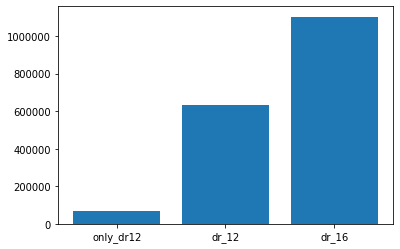

In [8]:
plt.bar(['only_dr12','dr_12','dr_16'],[len(only_in_dr12),len(sloan_data_dr12_qso),len(sloan_data_dr16_qso)])

In [9]:
print('Somente no DR12:{0} \n DR12:{1} \n DR16:{2}'.format(len(only_in_dr12),len(sloan_data_dr12_qso),len(sloan_data_dr16_qso)))

Somente no DR12:70613 
 DR12:632187 
 DR16:1102641


In [ ]:
# consultar se quasares variáveis estão nesse grupo 